In [1]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

TF version: 1.15.0
Hub version: 0.7.0
GPU is available


In [2]:
module_selection = ("mobilenet_v2_100_224", 224) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 #@param {type:"integer"}

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


In [3]:
data_dir = '/home/asus-pc/workspace/jyu/deeplearning/scripts/retrain/artists'

In [4]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 69 images belonging to 3 classes.
Found 282 images belonging to 3 classes.


In [5]:
do_fine_tuning = False #@param {type:"boolean"}

In [6]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [7]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
  metrics=['accuracy'])

In [8]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit_generator(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
8/8 [==============================] - 8s 1s/step - loss: 1.1469 - acc: 0.4436 - val_loss: 0.7399 - val_acc: 0.7500
Epoch 2/5
8/8 [==============================] - 2s 242ms/step - loss: 0.7893 - acc: 0.6459 - val_loss: 0.6956 - val_acc: 0.7656
Epoch 3/5
8/8 [==============================] - 2s 208ms/step - loss: 0.5673 - acc: 0.8697 - val_loss: 0.6074 - val_acc: 0.8594
Epoch 4/5
8/8 [==============================] - 2s 195ms/step - loss: 0.5052 - acc: 0.8680 - val_loss: 0.7811 - val_acc: 0.8281
Epoch 5/5
8/8 [==============================] - 2s 205ms/step - loss: 0.4959 - acc: 0.9310 - val_loss: 0.5842 - val_acc: 0.8438


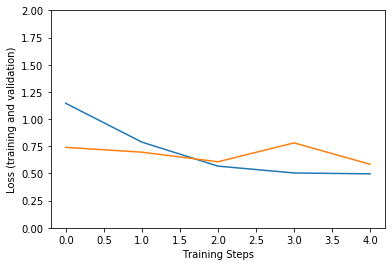

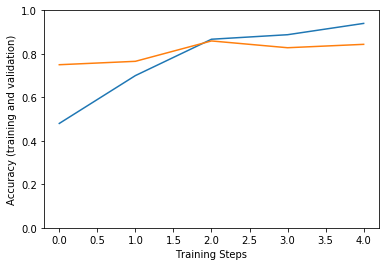

In [9]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])

In [11]:
model.save('../models/retrained_model.h5')

# Reference

https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_image_retraining.ipynb#scrollTo=QzW4oNRjILaq